# Descripción del problema de negocio.

Actualmente en la industria del vino la competencia esta en aumento, por lo que es muy importante saber que opinan los clientes. Las reseñas de vinos son fundamentales para que productores, distribuidores y futuros usuarios, comprendan que perciben los clientes en relacion a sus productos. Sin embargo, la gran cantidad de comentarios disponibles dificulta su análisis manual.

# Objetivo general.


El desafío consiste en analizar las reseñas de los vinos para identificar patrones de lenguaje, sentimientos predominantes y construir un modelo predictivo que permita clasificar vinos en Excelentes y Buenos, en función de su puntuación.

# Origen de los datos.

El dataset utilizado en este trabajo se obtuvo de: https://www.kaggle.com/datasets/priyamchoksi/global-wine-ratings-dataset

Los datos provienen de un archivo CSV titulado "Dataset wine-ratings.csv".

# Definición de las variables.


Variables principales:

Name: Nombre del vino (texto).

Región:	Region donde se produce el vino (texto)

Variety: variedad o tipo de uva (texto)

rating: 	puntuacion del vino	(numérica)

notes: Descriptive notes about the wine (string).

Para poder crear un modelo de clasificación binaria, vamos a crear la variable target a partir de la columna rating, si la nota es > a 90, la calificación va a ser "Excelente" (1) y si es < o = a 90 la calificación va a ser "Bueno" (0).

# Librerías a utilizar.

Pandas / Numpy → Manipulación y limpieza de datos

Matplotlib / Seaborn / WordCloud → Visualización y nubes de palabras

NLTK / TextBlob → NLP: tokenización, stopwords, lematización, sentimiento

Scikit-learn → TF-IDF, Bag of Words y modelo de Regresión Logística

# Importamos librerias y visualizamos el dataset.

In [36]:
!pip install -q gdown
!pip install -q catboost

# Importar librerías principales
import pandas as pd
import gdown
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout, GRU

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar el dataset
# URL de Google Drive (formato compartido)
url = "https://drive.google.com/uc?id=1ZOoYrUW1rCp8Hu2kU9a6bOWUzf3FlrQH"
output = "wine_ratings.csv"

# Descargar archivo
gdown.download(url, output, quiet=False)

# Leer CSV
df = pd.read_csv(output)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Downloading...
From: https://drive.google.com/uc?id=1ZOoYrUW1rCp8Hu2kU9a6bOWUzf3FlrQH
To: /content/wine_ratings.csv
100%|██████████| 13.4M/13.4M [00:00<00:00, 164MB/s]


,name,region,variety,rating,notes
0,1000 Stories Bourbon Barrel Aged Batch Blue Ca...,"Mendocino, California",Red Wine,91,"This is a very special, limited release of 100..."
1,1000 Stories Bourbon Barrel Aged Gold Rush Red...,California,Red Wine,89,The California Gold Rush was a period of coura...
2,1000 Stories Bourbon Barrel Aged Gold Rush Red...,California,Red Wine,90,The California Gold Rush was a period of coura...
3,1000 Stories Bourbon Barrel Aged Zinfandel 2013,"North Coast, California",Red Wine,91,"The wine has a deep, rich purple color. An int..."
4,1000 Stories Bourbon Barrel Aged Zinfandel 2014,California,Red Wine,90,Batch #004 is the first release of the 2014 vi...


In [37]:
# Ver información general
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32980 entries, 0 to 32979
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     32980 non-null  object
 1   region   32977 non-null  object
 2   variety  32621 non-null  object
 3   rating   32980 non-null  int64 
 4   notes    32980 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None


Podemos observar que tal como deciamos anteriormente, tenemos 5 columnas de tipo "object" y una de tipo numérica.

In [38]:
# Ver cantidad de nulos por columna
df.isnull().sum()

,0
name,0
region,3
variety,359
rating,0
notes,0


Vemos que en la columna Variety y Region hay nulos pero como vamos a trabajar con las columnas rating y notes, no lo vamos a modificar ni a eliminar.

In [39]:
df.describe().round(2) #hacemos la estadística descriptiva de la columna notas

,rating
count,32980.00
mean,91.19
std,2.19
min,85.00
25%,90.00
50%,91.00
75%,92.00
max,99.00


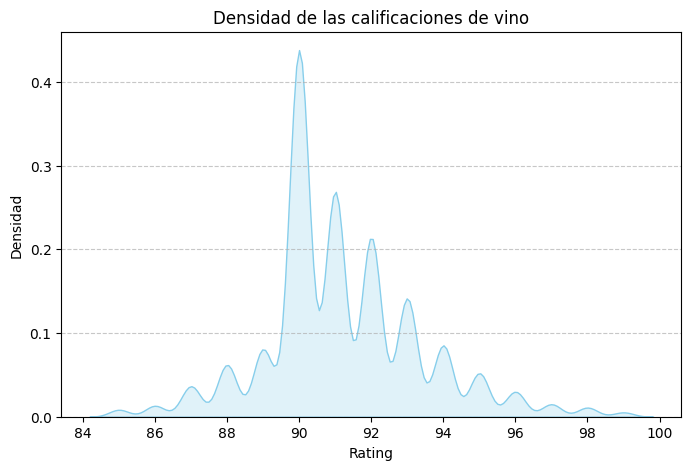

In [40]:
plt.figure(figsize=(8,5))
sns.kdeplot(df['rating'], fill=True, color='skyblue')
plt.title('Densidad de las calificaciones de vino')
plt.xlabel('Rating')
plt.ylabel('Densidad')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podemos observar que las calificaciones tienen el pico en los 90 puntos y que las calificaciones van de 85 a 99. Lo que sugiere que los vinos tienden a ser evaluados con puntajes altos, con una concentración notable justo en ese rango. Por lo que la columna target va a estar determinada por este puntaje, tal como lo observamos en el grafico para tener un dataset con una variable target equilibrada vamos a clasificar en "Buenos vinos" los que tengan un puntaje menor o igual que 90, y en "Excelentes vinos" los que tengan un puntaje mayor a 90.

In [41]:
# Creamos la columna 'target'
df['target'] = np.where(df['rating'] > 90, 1, 0)

# Vemos la Distribución de la variable target
print(df['target'].value_counts(normalize=True))

# Vista previa
df[['rating', 'target']].head(10)

target
1    0.563038
0    0.436962
Name: proportion, dtype: float64


,rating,target
0,91,1
1,89,0
2,90,0
3,91,1
4,90,0
5,91,1
6,92,1
7,92,1
8,94,1
9,87,0


Si analizamos la variable target podemos determinar que esta balanceada, ya que tenemos un 56% de vinos Excelentes, con calificacion mayor a 90 puntos y un 44% de vinos Buenos, con calificacion menor o igual a 90 puntos.

# Procesamiento de texto (NLP)

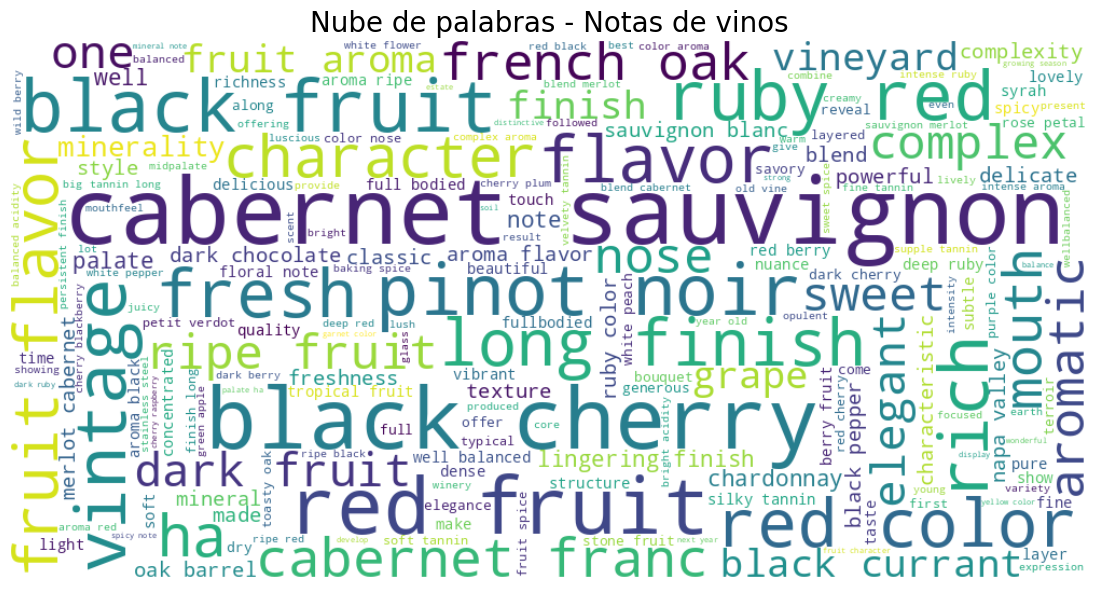

In [42]:
# Copiar la columna de texto
df['clean_notes'] = df['notes'].copy()

# Convertir a minúsculas
df['clean_notes'] = df['clean_notes'].str.lower()

# Quitar signos de puntuación, números y caracteres especiales
df['clean_notes'] = df['clean_notes'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Tokenizar
df['tokens'] = df['clean_notes'].apply(nltk.word_tokenize)

# Lematización
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remover stopwords y agregamos la palabra "wine"
stop_words = set(stopwords.words('english'))
stop_words.add('wine')
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Unir tokens limpios nuevamente en una cadena
df['clean_notes'] = df['tokens'].apply(lambda x: ' '.join(x))

# Unir todos los textos limpios en uno solo para la nube de palabras
all_words = ' '.join(df['clean_notes'])

# Generar la nube de palabras
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(all_words)

#  Mostrar la nube de palabras
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Notas de vinos', fontsize=20)
plt.show()

Si analizamos la nubo de palabra de todo el dataset, podemos ver que los tipos de vinos aparecen mucho (Por ej. "Cabernet Sauvignon", "Cabernet Franc", "Pinot Noir") y a demas observamos que palabras como flavor (sabor), red, fruit, cherry, black, estan relacionadas con las caracteristicas de los vinos.

Para un mejor analisis vamos a generar nubes de palabras de Bigramas y Trigramas pero clasificandolas segun la variable target.

In [43]:
def obtener_bigramas(df, target_value, top_n=20):
    df_filtrado = df[df['target'] == target_value]
    bigrams = []
    for tokens in df_filtrado['tokens']:
        bigrams.extend(list(ngrams(tokens, 2)))
    bigram_freq = Counter(bigrams).most_common(top_n)
    return bigram_freq

# Obtener bigramas para target=0 y target=1
bigrams_0 = obtener_bigramas(df, target_value=0, top_n=20)
bigrams_1 = obtener_bigramas(df, target_value=1, top_n=20)

# Crear DataFrame para mostrar lado a lado
df_bigrams = pd.DataFrame({
    'Bigramas Target 0': [' '.join(b[0]) for b in bigrams_0],
    'Frecuencia 0': [b[1] for b in bigrams_0],
    'Bigramas Target 1': [' '.join(b[0]) for b in bigrams_1],
    'Frecuencia 1': [b[1] for b in bigrams_1],
})

print(df_bigrams.to_string(index=False))

 Bigramas Target 0  Frecuencia 0  Bigramas Target 1  Frecuencia 1
      black cherry          1173 cabernet sauvignon          1973
cabernet sauvignon          1123       black cherry          1480
         red fruit           923          red fruit          1268
        pinot noir           820        black fruit          1197
         red color           767         pinot noir           936
          ruby red           759           ruby red           908
      fruit flavor           735     cabernet franc           894
       black fruit           679          red color           824
       long finish           665        long finish           813
   sauvignon blanc           547         french oak           660
        french oak           536       fruit flavor           608
  lingering finish           502      black currant           589
       fruit aroma           479         dark fruit           560
        ripe fruit           479         ripe fruit           539
    tropic

Observamos que hay bigramas que se repiten tanto para los buenos como para los excelentes vinos, pero con diferentes frecuencias, ademas hay bigramas no aparecen en ambas listas (Por ej, en vinos buenos "Sauvignon blanc", "lingering finish", "tropical fruit" y en vinos excelentes "cabernet franc", "black currant", "merlot cabernet", "dark chocolate", "napa valley", etc.). Esto nos podria dar un indicio de las caracteristicas que distinguen a ambos.

In [44]:
def obtener_trigramas(df, target_value, top_n=20):
    df_filtrado = df[df['target'] == target_value]
    trigrams = []
    for tokens in df_filtrado['tokens']:
        trigrams.extend(list(ngrams(tokens, 3)))
    trigram_freq = Counter(trigrams).most_common(top_n)
    return trigram_freq

# Obtener trigramas para ambos target values
trigrams_0 = obtener_trigramas(df, target_value=0, top_n=20)
trigrams_1 = obtener_trigramas(df, target_value=1, top_n=20)

# Crear DataFrame para mostrar lado a lado
df_trigrams = pd.DataFrame({
    'Trigramas Buenos vinos': [' '.join(t[0]) for t in trigrams_0],
    'Frec B.V.': [t[1] for t in trigrams_0],
    'Trigramas Excelentes vinos': [' '.join(t[0]) for t in trigrams_1],
    'Frec. E.V.': [t[1] for t in trigrams_1],
})

print(df_trigrams.to_string(index=False))


   Trigramas Buenos vinos  Frec B.V.  Trigramas Excelentes vinos  Frec. E.V.
           ruby red color        431              ruby red color         444
        french oak barrel        179       merlot cabernet franc         404
            deep ruby red        161   cabernet sauvignon merlot         331
cabernet sauvignon merlot        159    blend cabernet sauvignon         304
         intense ruby red        148       blend merlot cabernet         273
       aroma black cherry        138           french oak barrel         229
           ripe red fruit        135               deep ruby red         198
    long lingering finish        122            intense ruby red         196
     russian river valley        122             red black fruit         168
    merlot cabernet franc        121              new french oak         160
 blend cabernet sauvignon        116 cabernet sauvignon cabernet         149
          red black fruit        103   sauvignon merlot cabernet         149

En cuanto a los trigramas, sucede algo similar, se repiten la mayoria, pero hay tambien algunos exclusivos de cada lista (Por ej: buenos vinos "russian river valley", "french american oak", " deep red color" y en Excelentes vinos "new french oak", "cabernet sauvignon cabernet", "sauvignon merlot cabernet", "sauvignon cabernet franc", "deep ruby color", etc.)

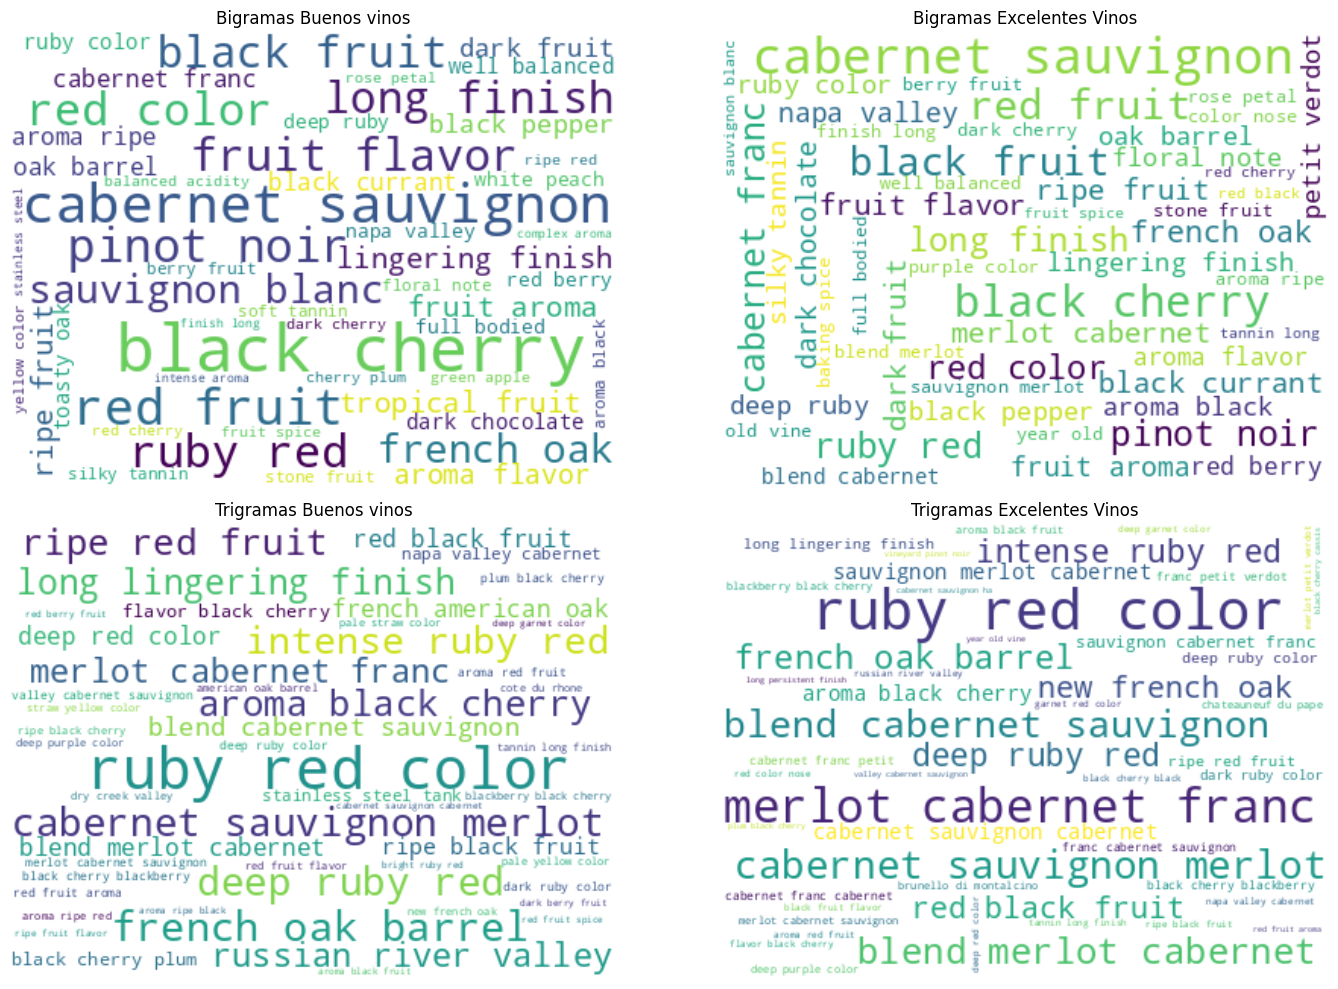

In [45]:
def obtener_ngrams_frecuencia(df, target_value, n, top_n=50):
    df_filtrado = df[df['target'] == target_value]
    ngrams_list = []
    for tokens in df_filtrado['tokens']:
        ngrams_list.extend(list(ngrams(tokens, n)))
    freq = Counter(ngrams_list).most_common(top_n)
    # Crear diccionario para WordCloud: clave es frase con espacios, valor es frecuencia
    freq_dict = {' '.join(gram): count for gram, count in freq}
    return freq_dict

# Obtener frecuencias para cada caso
freq_bigram_0 = obtener_ngrams_frecuencia(df, 0, 2)
freq_bigram_1 = obtener_ngrams_frecuencia(df, 1, 2)
freq_trigram_0 = obtener_ngrams_frecuencia(df, 0, 3)
freq_trigram_1 = obtener_ngrams_frecuencia(df, 1, 3)

# Crear nubes de palabras
wc_bigram_0 = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(freq_bigram_0)
wc_bigram_1 = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(freq_bigram_1)
wc_trigram_0 = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(freq_trigram_0)
wc_trigram_1 = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(freq_trigram_1)

# Plot lado a lado
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(wc_bigram_0, interpolation='bilinear')
axs[0, 0].set_title('Bigramas Buenos vinos')
axs[0, 0].axis('off')

axs[0, 1].imshow(wc_bigram_1, interpolation='bilinear')
axs[0, 1].set_title('Bigramas Excelentes Vinos')
axs[0, 1].axis('off')

axs[1, 0].imshow(wc_trigram_0, interpolation='bilinear')
axs[1, 0].set_title('Trigramas Buenos vinos')
axs[1, 0].axis('off')

axs[1, 1].imshow(wc_trigram_1, interpolation='bilinear')
axs[1, 1].set_title('Trigramas Excelentes Vinos')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

Podemos observar en nubes de palabras lo que veiamos anteriormente en el listado.

In [46]:
df[["clean_notes","target"]]

,clean_notes,target
0,special limited release story bourbon barrelag...,1
1,california gold rush wa period courage bravado...,0
2,california gold rush wa period courage bravado...,0
3,ha deep rich purple color intense raspberry fr...,1
4,batch first release vintage againmendocino zin...,0
...,...,...
32975,staying true consistent nature chardonnay cool...,0
32976,start honeysuckle dried peach movesinto dense ...,1
32977,cabernet sauvignon composed primarily grape gr...,1
32978,randolph stunning versatile weve ever bottled ...,0


# Entrenamiento del modelo

In [47]:
# X será "clean_notes" y la variable Y será "target"
X = df['clean_notes']
y = df['target']

# Separar 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de Train:", X_train.shape[0])
print("Tamaño de Test:", X_test.shape[0])

Tamaño de Train: 26384
Tamaño de Test: 6596


In [48]:
# Crear Bag of Words
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

# Entrenar modelo con BoW
model_bow = LogisticRegression(max_iter=30000)
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)

# Metricas
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Accuracy con BoW: {accuracy_bow:.2f}")

precision_bow = precision_score(y_test, y_pred_bow)
print(f"Precisión: {precision_bow:.2f}")

recall_bow = recall_score(y_test, y_pred_bow)
print(f"Recall: {recall_bow:.2f}")

f1_bow = f1_score(y_test, y_pred_bow)
print(f"F1 Score: {f1_bow:.2f}")

y_proba_bow = model_bow.predict_proba(X_test_bow)[:, 1]
roc_auc_bow = roc_auc_score(y_test, y_proba_bow)
print(f"ROC AUC: {roc_auc_bow:.2f}")

Accuracy con BoW: 0.66
Precisión: 0.69
Recall: 0.74
F1 Score: 0.71
ROC AUC: 0.71


In [49]:
# Crear vectorizador TF-IDF
tfidf = TfidfVectorizer(max_features=30000)

# Ajustar y transformar los datos
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Shape TF-IDF Train:", X_train_tfidf.shape)
print("Shape TF-IDF Test:", X_test_tfidf.shape)

Shape TF-IDF Train: (26384, 25227)
Shape TF-IDF Test: (6596, 25227)


In [50]:
# Crear y entrenar modelo
model = LogisticRegression()

model.fit(X_train_tfidf, y_train)

# Predicciones
y_pred = model.predict(X_test_tfidf)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.2f}")

precision = precision_score(y_test, y_pred)
print(f"Precisión: {precision:.2f}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)
y_proba = model.predict_proba(X_test_tfidf)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy del modelo: 0.67
Precisión: 0.68
Recall: 0.78
F1 Score: 0.73
ROC AUC: 0.73


Observando los resultados de la regresion logistica, utilizando TF-IDF y Bag of Words, para los siguientes modelos vamos a quedarnos con TF-IDF ya que tiene los resultados sobre todo en Recall y Roc Auc son mejores.

In [51]:
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Definir modelo CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=1000,          # número de árboles
    learning_rate=0.1,       # tasa de aprendizaje
    depth=8,                 # profundidad de árboles
    loss_function='Logloss', # para binario
    eval_metric='Accuracy',
    verbose=100,
    random_state=42)

# Entrenar
cat_model.fit(X_train_tfidf, y_train)

# Predicciones
y_pred = cat_model.predict(X_test_tfidf)
y_proba = cat_model.predict_proba(X_test_tfidf)[:, 1]

# Métricas
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

0:	learn: 0.5968390	total: 4.13s	remaining: 1h 8m 41s
100:	learn: 0.6825728	total: 2m 39s	remaining: 23m 35s
200:	learn: 0.7394633	total: 5m 8s	remaining: 20m 27s
300:	learn: 0.7788432	total: 7m 34s	remaining: 17m 36s
400:	learn: 0.8063220	total: 9m 56s	remaining: 14m 51s
500:	learn: 0.8302001	total: 12m 18s	remaining: 12m 15s
600:	learn: 0.8496437	total: 14m 39s	remaining: 9m 43s
700:	learn: 0.8651834	total: 17m	remaining: 7m 15s
800:	learn: 0.8787902	total: 19m 21s	remaining: 4m 48s
900:	learn: 0.8900091	total: 21m 50s	remaining: 2m 23s
999:	learn: 0.8998257	total: 24m 8s	remaining: 0us
Accuracy: 0.68
Precision: 0.70
Recall: 0.78
F1 Score: 0.73
ROC AUC: 0.74

Matriz de Confusión:
[[1627 1260]
 [ 825 2884]]


# RNN - Redes Neuronales Recurrentes

Sistemas de recomendación : Desarrollar algoritmos para sugerir vinos en función de las preferencias de los usuarios y valoraciones anteriores, mejorando las recomendaciones de vinos personalizadas.

In [17]:
# Definimos la cantidad máxima de palabras que queremos considerar en el vocabulario
max_words = 30000

# Definimos la longitud máxima que cada reseña puede tener
max_len = 100

# Creamos el tokenizador y configuramos el número máximo de palabras y un token para palabras desconocidas
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# Ajustamos el tokenizador al texto de las reseñas
tokenizer.fit_on_texts(df['clean_notes'])

# Convertimos las reseñas en texto a secuencias numéricas, donde cada palabra se representa por un índice
sequences = tokenizer.texts_to_sequences(df['clean_notes'])

# Usamos pad_sequences para rellenar o recortar las secuencias de texto para que todas tengan la misma longitud
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Extraemos las etiquetas (valores 0 o 1, que podrían representar una valoración o clase binaria) como un arreglo NumPy
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Creamos un modelo secuencial, es decir, apilamos las capas una tras otra
model_rnn = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')])

# Compilamos el modelo:
# - 'loss='binary_crossentropy'' define la función de pérdida adecuada para problemas de clasificación binaria.
# - 'optimizer='adam'' selecciona el optimizador Adam, que es un algoritmo eficiente para actualizar los pesos.
# - 'metrics=['accuracy']' nos indica que evaluaremos la precisión del modelo durante el entrenamiento.
model_rnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# Entrenamos el modelo usando los datos de entrenamiento y validamos con los datos de prueba
history = model_rnn.fit(
    # 'X_train' son los datos de entrada (características de entrenamiento) y 'y_train' son las etiquetas (resultados deseados) correspondientes
    X_train, y_train,

    # 'epochs=5' indica cuántas veces el modelo recorrerá todo el conjunto de datos durante el entrenamiento
    # Cada "época" significa que el modelo ha visto todos los datos una vez
    epochs=5,

    # 'batch_size=32' especifica el tamaño del lote de datos que el modelo usará en cada actualización de los pesos
    # En cada paso del entrenamiento, el modelo ajusta sus pesos utilizando 32 ejemplos a la vez
    batch_size=32,

    # 'validation_data=(X_test, y_test)' se pasa el conjunto de datos de prueba para evaluar el modelo después de cada época
    # Esto permite verificar cómo el modelo está generalizando a nuevos datos (no vistos durante el entrenamiento)
    validation_data=(X_test, y_test)
)


Epoch 1/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5595 - loss: 0.6876 - val_accuracy: 0.5626 - val_loss: 0.6885
Epoch 2/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.5522 - loss: 0.6892 - val_accuracy: 0.5623 - val_loss: 0.6862
Epoch 3/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5515 - loss: 0.6897 - val_accuracy: 0.5620 - val_loss: 0.6864
Epoch 4/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5567 - loss: 0.6872 - val_accuracy: 0.5623 - val_loss: 0.6860
Epoch 5/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.5648 - loss: 0.6861 - val_accuracy: 0.5623 - val_loss: 0.6907


In [20]:
# Mostramos el resumen del modelo: esto nos dará detalles sobre cada capa y el número de parámetros entrenables en el modelo.
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,784,965 (22.07 MB)

 Trainable params: 1,928,321 (7.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,856,644 (14.71 MB)

In [21]:
# Evaluamos el modelo con los datos de prueba (x_test, y_test)
loss_rnn, accuracy_rnn = model_rnn.evaluate(X_test, y_test)

# Mostramos los resultados
print(f"Pérdida en test: {loss_rnn:.4f}")
print(f"Precisión en test: {accuracy_rnn:.4f}")


207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5693 - loss: 0.6887
Pérdida en test: 0.6907
Precisión en test: 0.5623


## LSTM

In [22]:
# Creamos el modelo secuencial con una capa LSTM
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')])

# Compilamos el modelo
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# Entrenamiento
model_lstm.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 58s 66ms/step - accuracy: 0.5647 - loss: 0.6858
Epoch 2/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - accuracy: 0.5610 - loss: 0.6861
Epoch 3/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - accuracy: 0.5629 - loss: 0.6851
Epoch 4/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.5581 - loss: 0.6873
Epoch 5/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - accuracy: 0.5623 - loss: 0.6860


In [23]:
# Evaluamos el modelo con los datos de prueba
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)

# Mostramos los resultados
print(f"Pérdida en test: {loss_lstm:.4f}")
print(f"Precisión en test: {accuracy_lstm:.4f}")

207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5695 - loss: 0.6833
Pérdida en test: 0.6854
Precisión en test: 0.5623


In [24]:
# Mostramos el resumen del modelo
# Mostramos una tabla con las capas, la cantidad de parámetros entrenables y la forma de salida de cada una.

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,859,269 (22.35 MB)

 Trainable params: 1,953,089 (7.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,906,180 (14.90 MB)

In [25]:
# Creamos el modelo secuencial con una capa LSTM
model_lstm2 = Sequential([
    Embedding(input_dim=max_words, output_dim=96, input_length=max_len),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

# Compilamos el modelo
model_lstm2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# Entrenamos
model_lstm2.fit(X_train, y_train, batch_size=32, epochs=5)

# Evaluamos el modelo
loss_lstm2, accuracy_lstm2 = model_lstm2.evaluate(X_test, y_test)

# Mostramos los resultados
print(f"Pérdida en test: {loss_lstm2:.4f}")
print(f"Precisión en test: {accuracy_lstm2:.4f}")

Epoch 1/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 147s 175ms/step - accuracy: 0.5572 - loss: 0.6878
Epoch 2/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 146s 176ms/step - accuracy: 0.5667 - loss: 0.6848
Epoch 3/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 201s 175ms/step - accuracy: 0.5638 - loss: 0.6854
Epoch 4/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 200s 174ms/step - accuracy: 0.5607 - loss: 0.6855
Epoch 5/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 202s 174ms/step - accuracy: 0.5622 - loss: 0.6856
207/207 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5708 - loss: 0.6829
Pérdida en test: 0.6850
Precisión en test: 0.5632


## GRU

In [26]:
# Se crea el modelo GRU secuencial
model_gru = Sequential([
    Embedding(input_dim=30000, output_dim=96, input_length=200),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),  # Capa densa (fully connected) con 64 neuronas y activación ReLU
    Dense(1, activation='sigmoid')  # Capa de salida con una neurona y activación sigmoide (clasificación binaria)
])

# COMPILAMOS
# Se compila el modelo con función de pérdida binaria, optimizador Adam y se mide la exactitud
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Muestra la arquitectura del modelo
model_gru.summary()

# ENTRENAMOS
# Entrena el modelo con los datos X (entradas) e y (etiquetas), durante 5 épocas, en lotes de 32 muestras y reserva el 20% para validación
model_gru.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)


# EVALUAMOS

loss_gru, accuracy_gru = model_gru.evaluate(X_test, y_test)  # Evalúa el modelo ya entrenado sobre los datos de prueba (X_test e y_test), devolviendo la pérdida y la precisión

print(f"Pérdida en test: {loss_gru:.4f}")  # Imprime la pérdida del modelo en el conjunto de testeo, con 4 decimales
print(f"Precisión en test: {accuracy_gru:.4f}")  # Imprime la precisión (accuracy) en el conjunto de testeo, con 4 decimales


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 125s 146ms/step - accuracy: 0.5636 - loss: 0.6865 - val_accuracy: 0.5550 - val_loss: 0.6874
Epoch 2/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 140s 144ms/step - accuracy: 0.5666 - loss: 0.6847 - val_accuracy: 0.5550 - val_loss: 0.6878
Epoch 3/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 141s 143ms/step - accuracy: 0.5712 - loss: 0.6833 - val_accuracy: 0.5550 - val_loss: 0.6873
Epoch 4/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 117s 142ms/step - accuracy: 0.5685 - loss: 0.6846 - val_accuracy: 0.5550 - val_loss: 0.6876
Epoch 5/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 148s 149ms/step - accuracy: 0.5629 - loss: 0.6845 - val_accuracy: 0.5552 - val_loss: 0.6892
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5722 - loss: 0.6820
Pérdida en test: 0.6854
Precisión en test: 0.5638


# Comparamos resultados

In [52]:
# Creamos una lista de diccionarios con los resultados de cada modelo
resultados = [
    {'Modelo': 'RNN',   'Loss': loss_rnn,   'Accuracy': accuracy_rnn},
    {'Modelo': 'LSTM',  'Loss': loss_lstm,  'Accuracy': accuracy_lstm},
    {'Modelo': 'LSTM2', 'Loss': loss_lstm2, 'Accuracy': accuracy_lstm2},
    {'Modelo': 'GRU',   'Loss': loss_gru,   'Accuracy': accuracy_gru}
]

# Convertimos la lista de diccionarios en un DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostramos el DataFrame
print(df_resultados)


  Modelo      Loss  Accuracy
0    RNN  0.690719  0.562311
1   LSTM  0.685427  0.562311
2  LSTM2  0.684959  0.563220
3    GRU  0.685440  0.563827


# Transformers

In [28]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Activar mixed precision para GPUs modernas
mixed_precision.set_global_policy("mixed_float16")

# Modelo preentrenado en inglés
model_name = "bert-base-uncased"

# Cargar tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Cargar modelo TensorFlow desde pesos de PyTorch
model_transformer = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    from_pt=True  # <- crucial para evitar el TypeError
)

# Tokenizar tus textos
inputs = tokenizer(
    df['notes'].tolist(),  # Ajusta el nombre de la columna de tus reseñas
    return_tensors='tf',
    padding=True,
    truncation=True,
    max_length=10  # Puedes aumentar según la longitud de tus textos
)

# Preparar labels
labels = y if isinstance(y, (list, tuple)) else y.values if hasattr(y, "values") else y

# Compilar el modelo
model_transformer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Entrenar el modelo
model_transformer.fit(
    x=inputs,
    y=labels,
    batch_size=10,
    epochs=3,
    validation_split=0.2
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Epoch 1/3
2639/2639 [==============================] - 6999s 3s/step - loss: 0.6946 - accuracy: 0.5481 - val_loss: 0.6873 - val_accuracy: 0.5550
Epoch 2/3
2639/2639 [==============================] - 7000s 3s/step - loss: 0.6881 - accuracy: 0.5595 - val_loss: 0.6876 - val_accuracy: 0.5550
Epoch 3/3
2639/2639 [==============================] - 7066s 3s/step - loss: 0.7220 - accuracy: 0.5373 - val_loss: 0.6873 - val_accuracy: 0.5550


Observamos que se pierde mucho y el accurancy no es mejor que en otros modelos, ademas de que utiliza muchos recursos y demora mucho tiempo.

In [53]:
import pandas as pd

# Resultados BoW
resultados_modelos = [
    {
        'Modelo': 'Logistic Regression (BoW)',
        'Accuracy': accuracy_bow,
        'Precision': precision_bow,
        'Recall': recall_bow,
        'F1': f1_bow,
        'ROC AUC': roc_auc_bow
    },
    # Resultados TF-IDF
    {
        'Modelo': 'Logistic Regression (TF-IDF)',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC AUC': roc_auc
    },
    # Resultados CatBoost
    {
        'Modelo': 'CatBoost (TF-IDF)',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }
]

# Crear DataFrame
df_resultados_nlp = pd.DataFrame(resultados_modelos)

# Mostrar tabla
print(df_resultados_nlp)

                         Modelo  Accuracy  Precision    Recall        F1  \
0     Logistic Regression (BoW)  0.664797   0.688096  0.738744  0.712521   
1  Logistic Regression (TF-IDF)  0.674196   0.683962  0.781882  0.729652   
2             CatBoost (TF-IDF)  0.683899   0.695946  0.777568  0.734496   

    ROC AUC  
0  0.709137  
1  0.725988  
2  0.736156  


Viendo los resultados del resto de los modelos, vamos a seleccionar CatBoost, el cual tiene un buen rendimiento de casi el 70% de acierto.

# Validacion cruzada

Aplicamos validacion cruzada para el modelo "Cat_model" que es el que seleccionamos.

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Validación cruzada (5 folds)
cv_scores = cross_val_score(
    cat_model,
    X_train_tfidf,
    y_train,
    cv=3,
    scoring='accuracy',
    n_jobs=-1  # usa todos los cores disponibles
)

# Resultados
print("Accuracy por fold:", cv_scores)
print(f"Accuracy promedio: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Accuracy por fold: [0.66526435 0.66969869 0.67034342]
Accuracy promedio: 0.668 ± 0.002


Podemos observar que los resultados de la validacion cruzada nos indican que el modelo predice de manera correcta.

In [65]:
# Paso 1: Seleccionar una reseña real del DataFrame
indice = 300  # Cambiá este número para ver otra reseña
oracion_real = df['notes'].iloc[indice]
valoracion_real = df['target'].iloc[indice]

# Paso 2: Transformar la reseña con el TF-IDF entrenado
oracion_tfidf = tfidf.transform([oracion_real])

# Paso 3: Predecir con el modelo CatBoost
prediccion_proba = cat_model.predict_proba(oracion_tfidf)[:, 1][0]
valoracion_predicha = 1 if prediccion_proba >= 0.5 else 0

# Paso 4: Mostrar resultados
print(f"Reseña: {oracion_real}")
print(f"Valoración real: {valoracion_real}")
print(f"Valoración predicha: {valoracion_predicha}")
print(f"Probabilidad predicha: {prediccion_proba:.4f}")

Reseña: The profound relationship between the sun and the altitude of the Andes inspired us to explore other paths. The result is this Cabernet Sauvignon, with which we wish to share the expression of a mythical variety, whose echoes of freshness and seduction make it stand out for its elegance.
Valoración real: 1
Valoración predicha: 1
Probabilidad predicha: 0.6198


# Ingresamos una nueva reseña

In [69]:
# Nueva reseña que querés evaluar
nueva_resena = "It has a balance of fruit, acidity, bitterness, and body. Tannins, present in red wines, provide structure and astringency. It presents a harmonious combination of these elements"
# Transformar con el TF-IDF entrenado
nueva_tfidf = tfidf.transform([nueva_resena])

# Predecir con CatBoost
prediccion_proba = cat_model.predict_proba(nueva_tfidf)[:, 1][0]
valoracion_predicha = 1 if prediccion_proba >= 0.5 else 0

# Mostrar resultados
print(f"Reseña: {nueva_resena}")
print(f"Valoración predicha: {valoracion_predicha}")
print(f"Probabilidad predicha: {prediccion_proba:.4f}")

Reseña: It has a balance of fruit, acidity, bitterness, and body. Tannins, present in red wines, provide structure and astringency. It presents a harmonious combination of these elements
Valoración predicha: 1
Probabilidad predicha: 0.6498


Chequeamos con una reseña nueva y predice de buena forma, con una probabilidad similar a la media del modelo.